# OMGeEP

# Download dependencies

In [ ]:
# %pip install lightgbm scikit-learn pandas numpy joblib
# %pip install iterative-stratification
# %pip install shap
# !pip install scikit-bio

# Import libraries

In [18]:
import ast
import re
import os
import numpy as np
import pandas as pd
import math
from skbio.stats.composition import clr
from typing import Optional

import warnings
warnings.filterwarnings('ignore')

# Global variables

In [2]:
OUTPUT_DIR = 'ifbdata/atlanteco_hack/OMGeEP/output_files'
SAMPLE_ID_COL = 'sample_id'
SITE_ID_COL = 'sampling_design_feature'

# General_Helper_functions

In [3]:
def get_most_variable_omics(df:pd.DataFrame, N:int=200, ID_col:str=SAMPLE_ID_COL) -> pd.DataFrame:
    """
    df: metaomic df
    N: Top N most variable genes
    """
    # Get all columns except SAMPLE_ID_COL
    numeric_cols = df.columns.drop(SAMPLE_ID_COL)
    # Convert to numeric, invalid values become NaN
    df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')
    copied_df = df.copy()
    copied_df.set_index(ID_col,inplace=True)
    omics_variance = copied_df.var(axis=1)
    # Rank omics by variance
    top_X = N   # choose the number of hits you want
    top_omics = omics_variance.nlargest(top_X).index
    copied_df_top = copied_df.loc[top_omics]
    X = copied_df_top.T
    return X

In [4]:
def create_sample_id_mapping(file_path:str) -> pd.DataFrame:
    mapping_file = pd.read_csv(file_path)
    mapping_file = mapping_file[['sample-id', 'station-label']]
    mapping_file.rename(columns={'sample-id':SAMPLE_ID_COL, 'station-label':SITE_ID_COL}, inplace=True)
    return mapping_file

In [24]:
def clr_transform_skbio(df: pd.DataFrame, pseudocount: float = 1e-6) -> pd.DataFrame:
    """
    Apply CLR transformation using scikit-bio library.
    
    Parameters
    ----------
    df : pd.DataFrame
        Input dataframe with samples as index and features as columns.
    pseudocount : float, default=1e-6
        Pseudocount for zero replacement. Required since scikit-bio CLR
        doesn't handle zeros automatically.
    
    Returns
    -------
    pd.DataFrame
        CLR-transformed dataframe.
        
    Note
    ----
    Requires: pip install scikit-bio
    """
    # Validate input
    if df.empty:
        raise ValueError("Input DataFrame is empty")
    
    if (df < 0).any().any():
        raise ValueError("Input data contains negative values")
    
    # Handle zeros - scikit-bio CLR requires all positive values
    df_adj = df.copy()
    df_adj[df_adj == 0] = pseudocount
    
    # Apply CLR row-wise (each sample)
    clr_data = np.array([clr(row) for row in df_adj.values])
    
    return pd.DataFrame(clr_data, index=df.index, columns=df.columns)

## Create mapping

In [6]:
mapping_file = create_sample_id_mapping('Sample_ID_mapping.csv')
mapping = dict(zip(mapping_file['sample_id'], mapping_file['sampling_design_feature']))

# Read Genomics

## Helper functions

In [7]:
def normalize_gene_abundances(df:pd.DataFrame, method:str='tss', id_col:str=None) -> pd.DataFrame:
    """
    Normalize gene abundance data for comparison between samples.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame with gene IDs in first column and samples as remaining columns
    method : str, default 'tss'
        Normalization method:
        - 'tss': Total Sum Scaling (relative abundance, sums to 1)
        - 'tss_percent': Total Sum Scaling as percentages (sums to 100)
        - 'z_score': Z-score normalization (mean=0, std=1)
        - 'min_max': Min-max scaling (0 to 1 range)
        - 'log_tss': Log-transformed TSS (log10(TSS + pseudocount))
        - 'clr': Centered Log Ratio transformation
    id_col : str, optional
        Name of ID column. If None, assumes first column is ID
        
    Returns:
    --------
    pandas.DataFrame
        Normalized DataFrame with same structure as input
    """
    
    # Make a copy to avoid modifying original
    df_norm = df.copy()
    
    # Identify ID column
    if id_col is None:
        id_col = df.columns[0]
    
    # Get sample columns (all except ID column)
    sample_cols = [col for col in df.columns if col != id_col]
    
    # Extract abundance matrix
    abundance_matrix = df_norm[sample_cols].values
    
    if method == 'tss':
        # Total Sum Scaling - convert to relative abundances
        col_sums = abundance_matrix.sum(axis=0)
        normalized_matrix = abundance_matrix / col_sums
        
    elif method == 'tss_percent':
        # Total Sum Scaling as percentages
        col_sums = abundance_matrix.sum(axis=0)
        normalized_matrix = (abundance_matrix / col_sums) * 100
        
    elif method == 'z_score':
        # Z-score normalization (standardization)
        normalized_matrix = (abundance_matrix - abundance_matrix.mean(axis=0)) / abundance_matrix.std(axis=0)
        
    elif method == 'min_max':
        # Min-max scaling to [0, 1] range
        min_vals = abundance_matrix.min(axis=0)
        max_vals = abundance_matrix.max(axis=0)
        normalized_matrix = (abundance_matrix - min_vals) / (max_vals - min_vals)
        
    elif method == 'log_tss':
        # Log-transformed TSS (common in metagenomics)
        col_sums = abundance_matrix.sum(axis=0)
        tss_matrix = abundance_matrix / col_sums
        # Add small pseudocount to avoid log(0)
        pseudocount = 1e-10
        normalized_matrix = np.log10(tss_matrix + pseudocount)
        
    elif method == 'clr':
        # Centered Log Ratio transformation
        # Add small pseudocount to avoid log(0)
        pseudocount = 1e-10
        log_matrix = np.log(abundance_matrix + pseudocount)
        geometric_means = log_matrix.mean(axis=0)
        normalized_matrix = log_matrix - geometric_means
        
    else:
        raise ValueError(f"Unknown normalization method: {method}")
    
    # Replace the sample columns with normalized values
    df_norm[sample_cols] = normalized_matrix
    
    return df_norm
    

In [8]:
def read_genomic_data(genomic_data_path:str, rows_to_skip:int=7) -> pd.DataFrame:

    # read df
    gen_df = pd.read_csv(genomic_data_path, sep='\t')
    # rename gene id row to ID
    gen_df.rename(columns={'Unnamed: 0':SAMPLE_ID_COL}, inplace=True)
    # remove metaparams
    gen_df = gen_df.iloc[rows_to_skip:]
    # convert NAN to 0
    gen_df.fillna(0, inplace=True)
    # change values to numeric (expect geneID)
    sample_cols = gen_df.columns.drop(SAMPLE_ID_COL)
    gen_df[sample_cols] = gen_df[sample_cols].apply(pd.to_numeric, errors='coerce')

    # Remove samples with no genes
    # 1. Calculate column sums for sample columns
    col_sums = gen_df[sample_cols].sum()
    # 2. Find columns with zero sum
    zero_sum_cols = col_sums[col_sums == 0].index.tolist()
    # 3. Remove zero-sum columns
    if zero_sum_cols:
        gen_df = gen_df.drop(columns=zero_sum_cols)

    # reset index
    gen_df.reset_index(drop=True, inplace=True)
    
    # normalize the results per sample
    gen_df_normalized = normalize_gene_abundances(gen_df, method='tss', id_col=SAMPLE_ID_COL)

    # return normalized df
    return gen_df_normalized

## Running genomic code

In [20]:
ben_gen_df = read_genomic_data(genomic_data_path='ifbdata/atlanteco_hack/MetaGenomics/BenguelaCurrent_GeneAb/BenguelaCurrent_ffn_GeneAb_T.tsv')

In [21]:
# Get top 200 genes
top_200_ben_genes = get_most_variable_omics(ben_gen_df, 200)

In [ ]:
# index the mapping and group by site
top_200_ben_genes.index = top_200_ben_genes.index.map(mapping)
top_200_ben_genes = top_200_ben_genes.groupby(top_200_ben_genes.index).mean()

In [ ]:
# CLR the results
clr_gene_data = clr_transform_skbio(top_200_ben_genes)

In [11]:
# wedd_gen_df = read_genomic_data(genomic_data_path='ifbdata/atlanteco_hack/MetaGenomics/WeddellSea_GeneAb/WeddellSea_ffn_GeneAb_T.tsv')

# Read environmental data

## Helper functions

In [29]:
def read_env_data(env_data_csv_path:str) -> pd.DataFrame:
    return pd.read_csv(env_data_csv_path)

## Run environmental results

In [31]:
# read data
env_df = read_env_data('machine_ready_env.csv')

# transpose
env_df_t = env_df.T
env_df_t.columns = env_df_t.iloc[0]
env_df_t = env_df_t.drop(env_df_t.index[0])
# drop cols with NAN
env_df_t.drop(columns=['Sum_Carotenes', 'Chlorophyll_a'],inplace=True)

env_df_t.head()
# # CLR the results
# clr_env_data = clr_transform_skbio(env_df_t)
# clr_env_data.head()

Feature,CTD temperature (degC) median,CTD salinity (psu) median,CTD oxygen (%) median,CTD fluorescence (mg/m3) median,NO2,NO3+NO2,PO4,Si(OH)4,Biomass (ugC l-),Synechococcus cell/mL,Prochlorococcus cell/mL,Pico-Nanoplancton cell/mL,Viruses total,Alfa diversity (Hill),NO3,R
MMA-071,-0.286,34.422,93.0,123.569,0.15,26.17,1.75,63.41,5.82,0.0,0.0,1050.0,3190000.0,178.345,26.02,-1.83
MMA-072,-0.114,33.9444,104.8,48.723,0.08,8.29,0.73,55.09,20.54,0.0,0.0,8420.0,14400000.0,235.321,8.21,-3.39
MMA-074,-1.015,33.0256,95.2,4.352,0.19,20.13,1.45,38.74,3.08,140.0,9870.0,5520.0,4300000.0,206.049,19.94,-3.07
MMA-076,-0.813,33.0732,95.3,1.887,0.22,22.4,1.59,38.58,2.19,0.0,0.0,7940.0,2230000.0,178.459,22.18,-3.04
MMA-077,-0.911,33.1779,94.6,3.723,0.19,21.66,1.55,44.06,2.61,0.0,20000.0,5840.0,2870000.0,237.841,21.47,-3.14


# Read Proteomics data

## Helper function

In [33]:
def top_variable_columns(df: pd.DataFrame, n: int) -> pd.DataFrame:
    """
    Selects the top N most variable numeric columns from a dataframe.
    
    Parameters:
        df (pd.DataFrame): Input dataframe with samples as rows and features (e.g., proteins) as columns.
        n (int): Number of most variable columns to select.
    
    Returns:
        pd.DataFrame: Dataframe containing only the top N most variable columns.
    """
    # Keep only numeric columns (ignore index-like or categorical columns)
    numeric_df = df.select_dtypes(include="number")
    
    # Compute variance
    variances = numeric_df.var(axis=0)
    
    # Select top N
    top_cols = variances.nlargest(n).index
    
    return numeric_df[top_cols]

## Running proteomic code

In [34]:
# read data
ben_prot_df = pd.read_csv('Ben_metaprot_normalised.csv', index_col=0)
# transpose
ben_prot_df_t = ben_prot_df.T
# take top variable values
ben_prot_top_200 = top_variable_columns(ben_prot_df_t, 200)
# CLR the results
clr_prot_data = clr_transform_skbio(ben_prot_top_200)
clr_prot_data.head()

sample_id,megahit_HN020_k141_129271.p1,trinity_HN006_TRINITY_DN216338_c0_g1_i1.p1,megahit_HN025_k141_9493.p1,transabyss_HN006_.k50R5032280.p1,transabyss_HN026_.k50R3537400.p2,velvet_HN020_NODE_697757_length_500_cov_2.436000.p1,transabyss_HN017_.k50R6170578.p1,trinity_HN022_TRINITY_DN52167_c0_g2_i1.p1,megahit_HN038_k141_179695.p2,transabyss_HN017_.k50R6263808.p3,...,trinity_HN017_TRINITY_DN7879_c0_g1_i7.p1,megahit_HN006_k141_241884.p1,transabyss_HN022_.k50S4732243.p1,megahit_HN020_k141_123454.p2,transabyss_HN038_.k50R5395401.p1,trinity_HN007_TRINITY_DN16693_c0_g2_i1.p1,trinity_HN002_TRINITY_DN8576_c0_g2_i13.p1,trinity_HN002_TRINITY_DN5531_c1_g1_i3.p2,trinity_HN039_TRINITY_DN4841_c0_g1_i1.p1,transabyss_HN035_.k20R25547656.p1
MMA-105,-19.402299,-19.402299,-19.402299,3.078795,1.743297,0.800856,6.077006,6.560226,5.027890,-19.402299,...,2.714648,3.234716,0.888628,-19.402299,4.218725,1.955056,3.173428,3.828618,3.862050,3.776893
MMA-106,0.788569,1.082606,-18.487442,-18.487442,3.744947,3.700692,5.126903,5.968751,4.056688,4.732249,...,3.656755,4.209253,2.371556,4.846441,5.088117,-0.814348,3.106551,4.176055,0.195973,4.143171
MMA-107,0.516613,-18.002702,-18.002702,2.388775,0.962124,0.435653,5.622321,5.971994,4.298237,5.357628,...,5.363671,4.471190,-18.002702,2.164271,4.765834,0.098395,5.063867,3.745155,-0.139071,5.047473
MMA-108,-0.522433,-19.995004,-19.995004,-19.995004,0.972631,-19.995004,4.751217,5.478385,3.094122,3.133391,...,2.517784,3.949788,0.353548,-19.995004,3.449545,-0.912225,3.309476,3.763203,1.704066,2.967540
MMA-109,-20.137212,2.937054,-20.137212,-20.137212,1.730296,-20.137212,5.255014,5.622197,3.643226,2.660041,...,1.982495,3.343710,0.582442,-20.137212,3.677912,-0.044226,3.484162,3.595024,2.230709,2.692527


# Read Metabolomic data (labels)

## Running metabolomic code

In [42]:
metabol_df = pd.read_csv('metabolomic_averaged_to_site.csv', index_col='sample_id')

# Verify values are numeric
metabol_df = metabol_df.apply(pd.to_numeric, errors='coerce')
# # CLR the results
clr_metabolic_data = clr_transform_skbio(metabol_df)
clr_metabolic_data.head()

,FT00002,FT00005,FT00017,FT00112,FT00326,FT00327,FT00357,FT00361,FT00373,FT00380,...,FT23171,FT23182,FT23264,FT23266,FT23363,FT23364,FT23371,FT23460,FT23476,FT23622
sample_id,,,,,,,,,,,,,,,,,,,,,
MMA-071,3.715497,0.689385,1.912224,1.793893,3.613329,4.650910,1.809518,3.698892,0.777013,0.957392,...,-1.102334,-2.187473,0.915460,0.054784,0.287090,-0.526637,-1.051703,1.003629,-0.679996,-1.246443
MMA-072,4.103452,0.039889,2.309352,1.758883,3.145449,5.187643,3.245406,5.855645,3.047815,1.932857,...,-1.201887,-1.982300,0.310180,-0.322233,-0.107952,-0.385510,-0.613160,0.552492,-2.694025,-1.695051
MMA-074,3.446028,-1.181808,1.629985,0.705906,2.232279,3.770240,2.146654,4.580935,1.814336,1.272686,...,-0.671234,-2.216899,1.491300,0.842592,0.852603,0.922244,-0.334497,1.476377,-0.967440,0.370223
MMA-076,4.991085,0.497846,3.211040,2.146770,1.090706,2.344289,3.057064,5.527938,2.327292,3.767743,...,-0.541820,-0.781745,1.132013,0.912457,1.241003,0.971205,0.236237,1.476271,-0.758136,1.165963
MMA-077,5.266633,0.383084,2.448663,3.585041,2.578313,2.363749,5.668948,6.311506,3.600588,3.474379,...,0.553974,0.005622,3.089659,2.382959,2.294434,1.545233,1.122132,3.073885,0.001944,-0.829346


# Run statistical model

In [43]:
common_sites = clr_gene_data.index.intersection(clr_prot_data.index).intersection(env_df_t.index)

top_200_ben_genes_shared_sites = clr_gene_data.loc[common_sites]
top_200_ben_prots_shared_sites = clr_prot_data.loc[common_sites]
env_features_shared_sites = env_df_t.loc[common_sites]

full_feature_table = pd.concat([top_200_ben_genes_shared_sites, top_200_ben_prots_shared_sites, env_features_shared_sites], axis=1)

In [53]:
clr_metabolic_data_shared_sites = clr_metabolic_data.loc[common_sites]
clr_metabolic_data_shared_sites.head()

,FT00002,FT00005,FT00017,FT00112,FT00326,FT00327,FT00357,FT00361,FT00373,FT00380,...,FT23171,FT23182,FT23264,FT23266,FT23363,FT23364,FT23371,FT23460,FT23476,FT23622
MMA-106,3.397726,-4.844770,1.655094,1.393919,1.226484,1.003449,3.847696,4.804196,1.854661,1.870996,...,6.175130,5.677382,2.578559,2.039788,1.883384,2.034302,0.573155,2.426527,0.731447,1.383112
MMA-108,4.114280,-4.043745,2.403176,2.203897,0.562963,0.408153,4.404500,5.517108,2.789141,2.685441,...,0.453434,-0.091401,1.044867,0.175357,0.373471,-0.210760,-1.187164,0.743950,-1.264792,-0.755450
MMA-114,2.735937,-1.607871,0.863772,1.759497,3.409339,5.217775,3.334683,4.169090,1.362457,1.821917,...,-27.942501,-27.942501,0.403419,-0.279556,-0.225218,-0.650794,-1.266043,0.234383,1.695956,-1.542385
MMA-115,4.263791,-1.348315,2.474993,1.434127,2.085665,5.023394,3.514101,4.479137,1.624252,3.287737,...,-2.345705,-4.887234,1.247866,-0.065884,-0.027547,-0.171011,-1.950682,0.910283,1.457621,-0.735748
MMA-123,3.407754,-1.547822,1.735034,1.080542,3.251548,6.652624,3.040184,3.868006,0.915508,-0.309559,...,0.111241,-1.589869,-0.010715,-0.786213,-1.263544,-1.673161,-2.005736,0.025415,0.604245,-4.934326


# Run Regression Models

In [47]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.linear_model import MultiTaskLassoCV
from sklearn.linear_model import ElasticNetCV

In [54]:
# prepare the data

X = full_feature_table
Y = clr_metabolic_data_shared_sites

X_scaled = StandardScaler().fit_transform(X)
Y_scaled = StandardScaler().fit_transform(Y)

# Run Code - ElasticNetCV

In [49]:
model = ElasticNetCV(l1_ratio=[.1, .5, .9], alphas=alphas, cv=2, max_iter=10000)
model.fit(X_scaled, Y_scaled.iloc[:, 0])  # try one metabolite first
print(sum(model.coef_ != 0), "nonzero coefficients")

NameError: name 'alphas' is not defined

# Run code - MultiTaskLassoCV

In [55]:
# Fit multitask lasso with cross-validation

alphas = np.logspace(-3, 1, 50)  # from very small to moderate
model = MultiTaskLassoCV(alphas=alphas, cv=3, max_iter=10000)
model.fit(X_scaled, Y_scaled)
print("Chosen alpha:", model.alpha_)

Chosen alpha: 6.866488450042998


In [56]:
# Get coefficients: features x metabolites
coefs = pd.DataFrame(model.coef_.T, index=X.columns, columns=Y.columns)

In [75]:
# Extract top features per metabolite
top_features_per_metabolite = {}
for metabolite in Y.columns:
    top_features = coefs[metabolite].abs().sort_values(ascending=False).head(5).index.tolist()
    top_features_per_metabolite[metabolite] = top_features

In [ ]:
# Show
for met, features in top_features_per_metabolite.items():
    print(f"Metabolite: {met}")
    print(f"Top features: {features}")
    print("=" * 50)

# Visualize results

In [59]:
import seaborn as sns
import matplotlib.pyplot as plt

In [60]:
heatmap_data = coefs.T  # metabolites in rows, features in columns

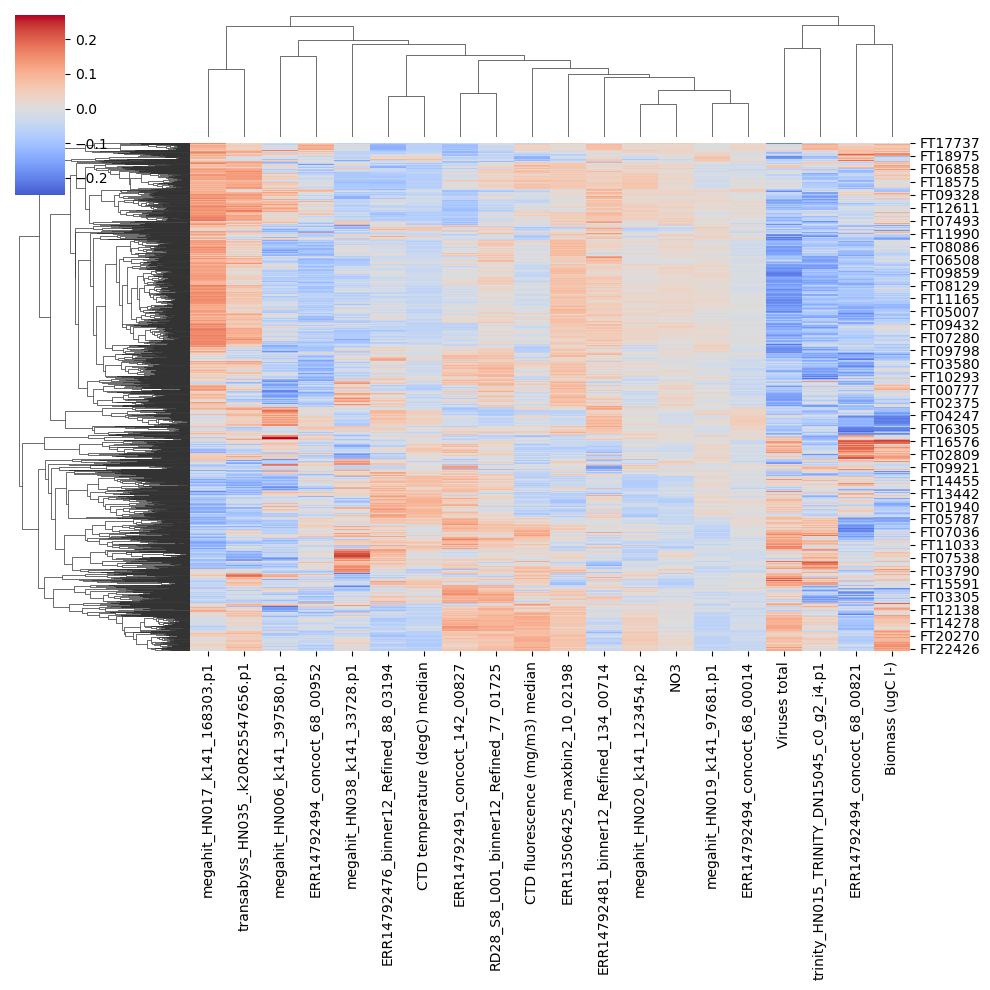

In [89]:
# Clustered heatmap (keep top N features for clarity)
top_features = coefs.abs().sum(axis=1).sort_values(ascending=False).head(20).index
sns.clustermap(heatmap_data[top_features], cmap='coolwarm', center=0)
plt.savefig('MultiTaskLassoCV_heatmap_top20_features.png', dpi=300)
plt.show()

In [62]:
print(top_features)

Index(['Viruses total', 'megahit_HN017_k141_168303.p1',
       'ERR14792494_concoct_68_00821',
       'trinity_HN015_TRINITY_DN15045_c0_g2_i4.p1',
       'megahit_HN006_k141_397580.p1', 'transabyss_HN035_.k20R25547656.p1',
       'Biomass (ugC l-)', 'megahit_HN038_k141_33728.p1',
       'ERR14792494_concoct_68_00952', 'ERR14792491_concoct_142_00827',
       'ERR14792476_binner12_Refined_88_03194', 'ERR13506425_maxbin2_10_02198',
       'ERR14792481_binner12_Refined_134_00714',
       'RD28_S8_L001_binner12_Refined_77_01725',
       'CTD fluorescence (mg/m3) median', 'CTD temperature (degC) median',
       'megahit_HN020_k141_123454.p2', 'NO3', 'megahit_HN019_k141_97681.p1',
       'ERR14792494_concoct_68_00014', 'ERR14792494_concoct_68_00633',
       'ERR13506425_maxbin2_10_02670', 'megahit_HN002_k141_333561.p1',
       'trinity_HN006_TRINITY_DN155912_c0_g1_i1.p1',
       'ERR14792470_binner23_Refined_85_02580', 'megahit_HN017_k141_310798.p1',
       'trinity_HN015_TRINITY_DN6655_c0_g1

# Analyze results

## 1. Summary statistics of coefficients


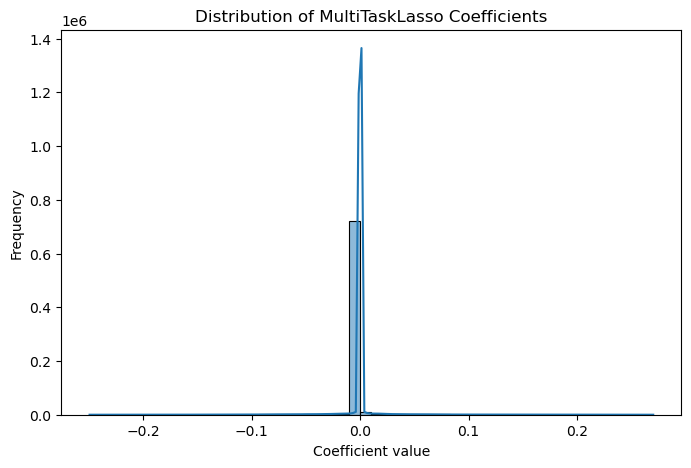

,count,mean,std,min,25%,50%,75%,max
FT00002,416.0,-0.000037,0.014257,-0.095706,0.0,0.0,0.0,0.112967
FT00005,416.0,0.000170,0.015204,-0.123804,0.0,0.0,0.0,0.127014
FT00017,416.0,-0.000083,0.014239,-0.097063,0.0,0.0,0.0,0.104596
FT00112,416.0,-0.000184,0.015114,-0.172435,0.0,0.0,0.0,0.099231
FT00326,416.0,0.000187,0.014962,-0.098087,0.0,0.0,0.0,0.154219
...,...,...,...,...,...,...,...,...
FT23364,416.0,0.000576,0.013883,-0.073875,0.0,0.0,0.0,0.115044
FT23371,416.0,-0.000049,0.012343,-0.180048,0.0,0.0,0.0,0.086974
FT23460,416.0,0.000515,0.013888,-0.073651,0.0,0.0,0.0,0.112279
FT23476,416.0,0.000198,0.014419,-0.110620,0.0,0.0,0.0,0.124923


In [88]:
# Overall distribution of coefficients
plt.figure(figsize=(8,5))
sns.histplot(coefs.values.flatten(), bins=50, kde=True)
plt.title("Distribution of MultiTaskLasso Coefficients")
plt.xlabel("Coefficient value")
plt.ylabel("Frequency")
plt.savefig('MultiTaskLassoCV_coef_dist.png', dpi=300)
plt.show()

# Summary stats
coef_summary = coefs.describe().T
coef_summary

## 2. Top features across all metabolites

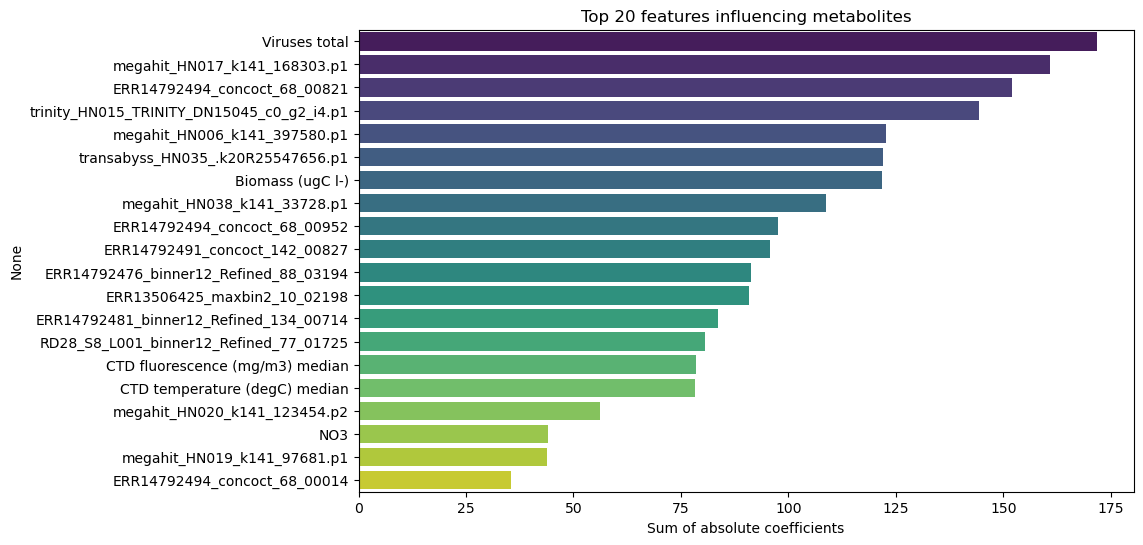

In [90]:
# Sum absolute coefficients across metabolites
feature_importance = coefs.abs().sum(axis=1).sort_values(ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=feature_importance.values[:20], y=feature_importance.index[:20], palette="viridis")
plt.title("Top 20 features influencing metabolites")
plt.xlabel("Sum of absolute coefficients")
plt.savefig('MultiTaskLassoCV_top20_influencing_features.png', dpi=300)
plt.show()

In [93]:
feature_importance.index[:20]

Index(['Viruses total', 'megahit_HN017_k141_168303.p1',
       'ERR14792494_concoct_68_00821',
       'trinity_HN015_TRINITY_DN15045_c0_g2_i4.p1',
       'megahit_HN006_k141_397580.p1', 'transabyss_HN035_.k20R25547656.p1',
       'Biomass (ugC l-)', 'megahit_HN038_k141_33728.p1',
       'ERR14792494_concoct_68_00952', 'ERR14792491_concoct_142_00827',
       'ERR14792476_binner12_Refined_88_03194', 'ERR13506425_maxbin2_10_02198',
       'ERR14792481_binner12_Refined_134_00714',
       'RD28_S8_L001_binner12_Refined_77_01725',
       'CTD fluorescence (mg/m3) median', 'CTD temperature (degC) median',
       'megahit_HN020_k141_123454.p2', 'NO3', 'megahit_HN019_k141_97681.p1',
       'ERR14792494_concoct_68_00014'],
      dtype='object')

In [107]:
ben_prot_annot = pd.read_csv('ifbdata/atlanteco_hack/MetaProteomics/Merged_Proteomics_Annotations/merged_prot_tax_ann_2025Tara.csv')

In [108]:
ben_prot_annot = ben_prot_annot.drop(columns=[col for col in ben_prot_annot.columns if col.startswith('SAME')])
cols_to_rem = ['counts', 'domain', 'supergroup', 'division', 'class', 'order',
       'family', 'genus', 'species']
ben_prot_annot = ben_prot_annot.drop(columns=[col for col in cols_to_rem])

In [112]:
filtered_prot_df = ben_prot_annot[ben_prot_annot['transcript_name'].isin(list(feature_importance.index[:20]))]
filtered_prot_df.head()

,transcript_name,seed_ortholog,evalue,score,eggNOG_OG,narr_OG_name,narrOG_cat,narr_OG_desc,best_OG_names,best_OG_cat,...,BRITE,KEGG_TC,CAZy,BiGG_Reaction,PFAMs,classification_level,full_classification,classification,max_pid,ambiguous
73,megahit_HN006_k141_397580.p1,7668.SPU_009433-tr,9.600000e-192,677.2,"COG5277@1|root,KOG0676@2759|Eukaryota,38FH3@33...",3D38N@33213|Bilateria,Z,Belongs to the actin family,3BID7@33208|Metazoa,Z,...,"ko00000,ko00001,ko03019,ko03021,ko03029,ko0303...",-,-,-,Actin,family,Eukaryota; Alveolata; Dinophyta; Dinophyceae; ...,Gonyaulacales,937.99,1
105,megahit_HN019_k141_97681.p1,400682.PAC_15727766,1.500000e-300,1039.3,"COG5022@1|root,KOG0161@2759|Eukaryota,38CVC@33...",3BBPR@33208|Metazoa,Z,Belongs to the TRAFAC class myosin-kinesin ATP...,3BBPR@33208|Metazoa,Z,...,"ko00000,ko00001,ko04147,ko04812",-,-,-,"DUF3513,FRG2,IF4E,IQ,Myosin_N,Myosin_head,Myos...",genus,Eukaryota; Opisthokonta; Metazoa; Cnidaria; SG...,Clytia,1455.97,0
114,megahit_HN017_k141_168303.p1,50452.A0A087G453,1.200000e-21,110.2,"28J54@1|root,2QRH9@2759|Eukaryota,37QWQ@33090|...",3HY5K@3699|Brassicales,C,The light-harvesting complex (LHC) functions a...,3G9KR@35493|Streptophyta,C,...,"ko00000,ko00001,ko00194",-,-,-,Chloroa_b-bind,supergroup,Eukaryota,Eukaryota,415.16,1
154,megahit_HN038_k141_33728.p1,10224.XP_002732020.1,1.500000e-76,292.0,"COG5023@1|root,KOG1376@2759|Eukaryota,38E06@33...",3CRFN@33213|Bilateria,Z,structural constituent of cytoskeleton,3BAUV@33208|Metazoa,Z,...,"ko00000,ko00001,ko03019,ko03036,ko04147,ko04812",-,-,-,"LRR_6,Tubulin,Tubulin_C",NaN,NaN,NaN,281.30,1
162,trinity_HN015_TRINITY_DN15045_c0_g2_i4.p1,29176.XP_003879894.1,8.000000e-155,553.1,"COG5277@1|root,KOG0676@2759|Eukaryota,3Y9P2@57...",3YTBV@5809|Sarcocystidae,Z,Belongs to the actin family,3Y9P2@5794|Apicomplexa,Z,...,"ko00000,ko04812",-,-,-,Actin,supergroup,Eukaryota,Eukaryota,562.60,1


## 3. Heatmap per metabolite (top features only)

In [82]:
first_5_cols = list(Y.columns)[:5]

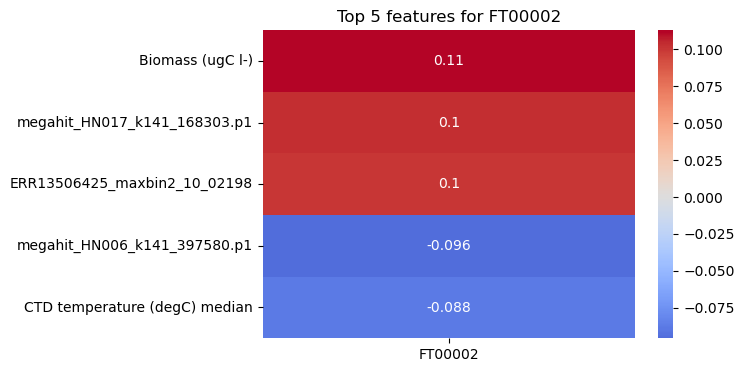

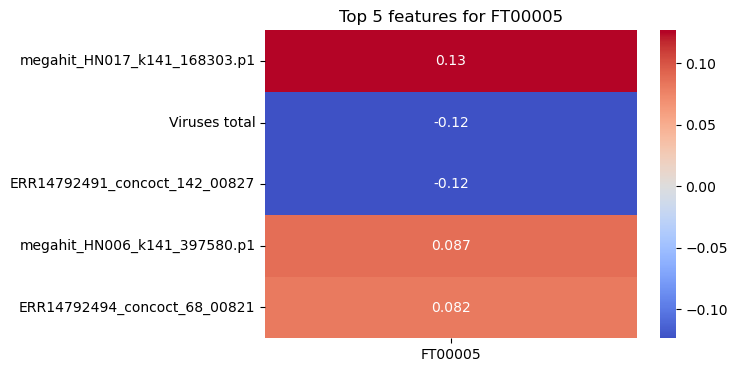

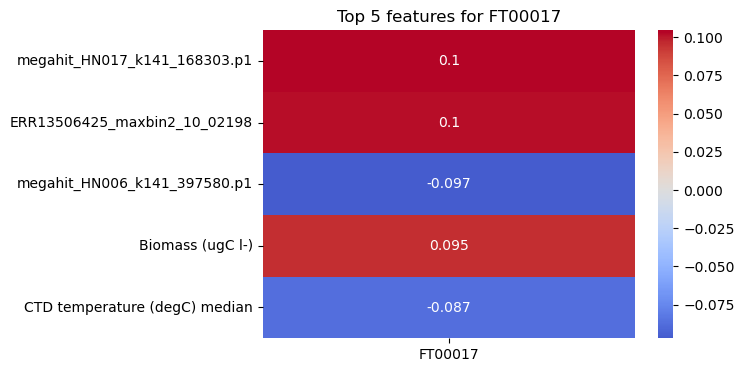

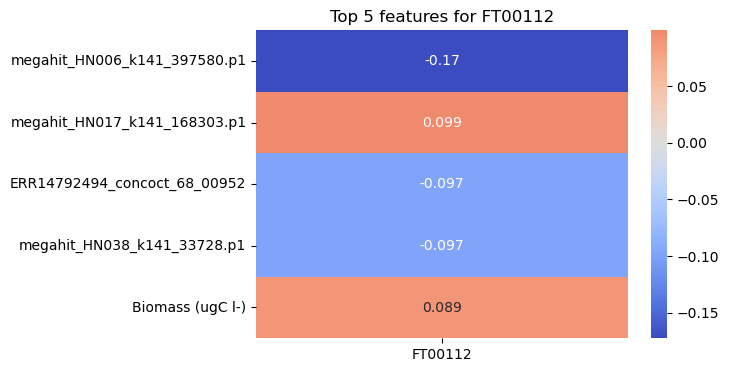

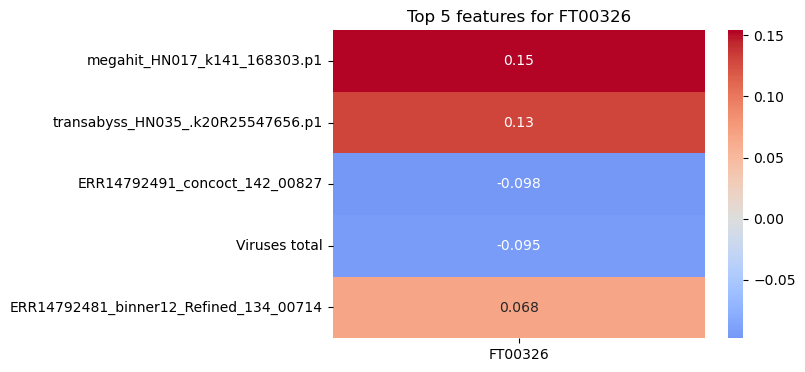

In [91]:
top_n = 5  # top features per metabolite
for metabolite in first_5_cols:
    top_feats = coefs[metabolite].abs().sort_values(ascending=False).head(top_n).index
    plt.figure(figsize=(6,4))
    sns.heatmap(coefs.loc[top_feats, metabolite].to_frame(), annot=True, cmap='coolwarm', center=0)
    plt.title(f"Top {top_n} features for {metabolite}")
    plt.savefig(f'MultiTaskLassoCV_top_{top_n}_features_for_met_{metabolite}.png', dpi=300)
    plt.show()

## 4. Network visualization (features <-> metabolites)

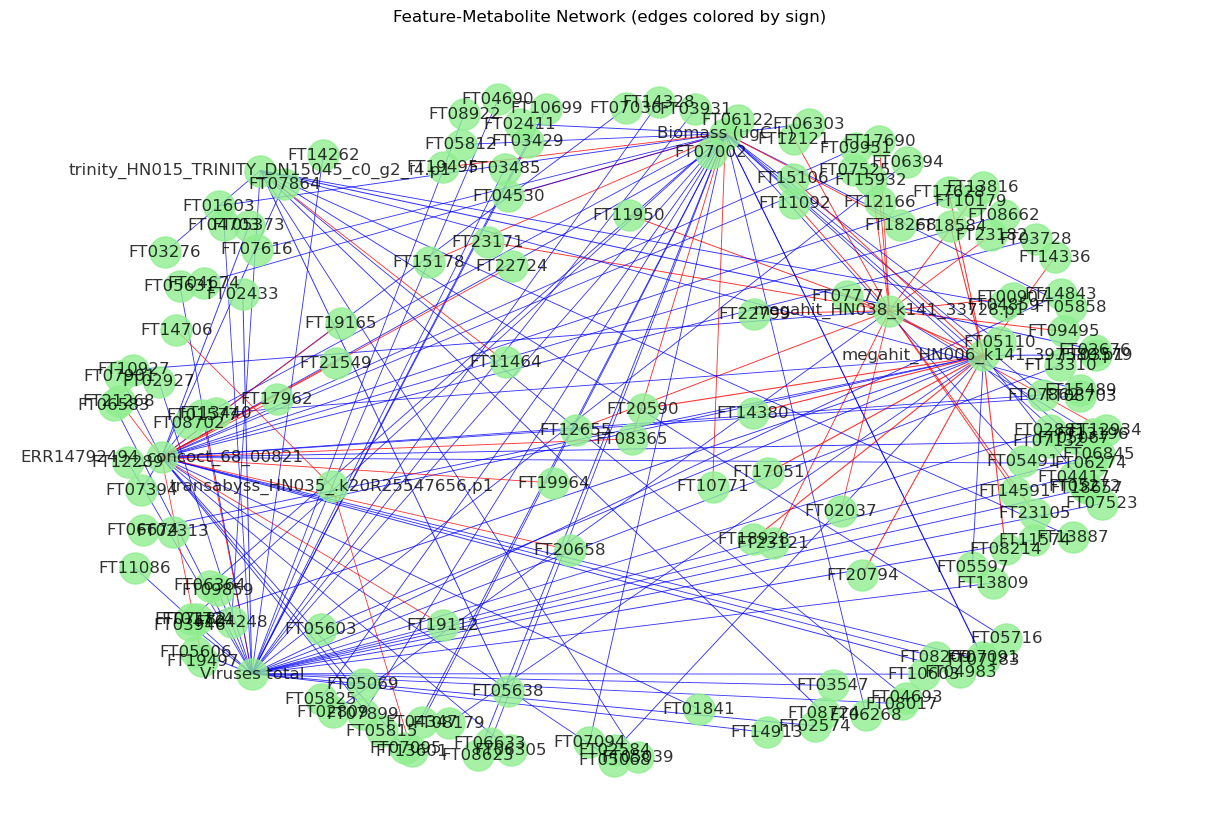

In [92]:
import networkx as nx

# Build bipartite network
G = nx.Graph()

# Threshold coefficients to focus on stronger associations
threshold = 0.2
for metabolite in Y.columns:
    for feature in X.columns:
        coef_val = coefs.loc[feature, metabolite]
        if abs(coef_val) > threshold:
            G.add_edge(feature, metabolite, weight=coef_val)

# Position nodes
pos = nx.spring_layout(G, k=0.3, seed=42)

plt.figure(figsize=(12,8))
edges = G.edges(data=True)
colors = ['red' if d['weight']>0 else 'blue' for (u,v,d) in edges]
weights = [abs(d['weight'])*3 for (u,v,d) in edges]
nx.draw(G, pos, with_labels=True, node_size=500, node_color='lightgreen', edge_color=colors, width=weights, alpha=0.8)
plt.title("Feature-Metabolite Network (edges colored by sign)")
plt.savefig('MultiTaskLassoCV_network_features_above_abs_0.2.png', dpi=300)
plt.show()

# Top-5 feature sums per metabolite

In [ ]:
threshold_n = 5  # number of top features per metabolite
results = []

for metabolite in coefs.columns:
    # get top 5 features (by absolute coefficient value)
    top_features = coefs[metabolite].abs().sort_values(ascending=False).head(threshold_n).index
    top_coef_values = coefs.loc[top_features, metabolite].values
    
    # compute sum of absolute values
    abs_sum = np.abs(top_coef_values).sum()
    
    # store results
    results.append({
        "metabolite": metabolite,
        "top_features": list(top_features),
        "coefficients": list(top_coef_values),
        "abs_sum": abs_sum
    })

# make dataframe
metabolite_df = pd.DataFrame(results)

# sort by abs_sum (descending)
metabolite_df = metabolite_df.sort_values("abs_sum", ascending=False).reset_index(drop=True)

In [115]:
metabolite_df.to_csv('most_explained_metabolites_by_top_5_features.csv')

# Save the results

In [74]:
import joblib

data_to_save = {
    'model': model,
    'X': X,
    'Y': Y,
    'X_scaled': X_scaled,
    'Y_scaled': Y_scaled,
    'coefs': coefs
}

joblib.dump(data_to_save, 'lasso_results.joblib')

['lasso_results.joblib']